# Off-policy Ensemble

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [2]:
from sklearn.linear_model import LogisticRegression
K_learners = 100

In [3]:
st_seed = 0
end_seed = 3000


In [18]:
st_exploration = 0
end_exploration = 5000

In [19]:
st_test = 5000
end_test = 7395


In [20]:
Xseed = X[st_seed:end_seed, :]
Xexplore_sample = X[st_exploration:end_exploration, :]
Xtest = X[st_test:end_test, :]
nchoices = y.shape[1]


In [21]:
actions_ensemble = np.zeros([K_learners, end_exploration-st_exploration], dtype=int)
rewards_ensemble = np.zeros([K_learners, end_exploration-st_exploration])
prob_actions_ensemble = np.zeros([K_learners, end_exploration-st_exploration])

In [22]:
for k in range(K_learners):
    sample_index = np.random.randint(st_seed, end_seed, size=3000)
    Xseed_sample = Xseed[sample_index, :]
    
    explorer = LogisticRegression(solver="lbfgs", max_iter=1500, multi_class='auto')
    explorer.fit(Xseed_sample, np.argmax(y[sample_index], axis=1))
    
    actions_ensemble[k] = explorer.predict(Xexplore_sample)
    rewards_ensemble[k] = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_ensemble[k]]

    ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
    ix_internal_actions = [ix_internal_actions[i] for i in actions_ensemble[k]]

    ix_internal_actions = np.array(ix_internal_actions)
    prob_actions_ensemble[k] = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]


In [23]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

In [24]:
reward_ensemble = np.empty([K_learners, ])

In [25]:
for k in range(K_learners):
    new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
    new_policy.fit(X=Xexplore_sample, a=actions_ensemble[k], r=rewards_ensemble[k], p=prob_actions_ensemble[k])
    mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    reward_ensemble[k] = mean_reward_ot





    

In [26]:
from collections import Counter

In [27]:
ensemble_predict = np.zeros([K_learners, end_test-st_test])
vote = np.zeros([end_test-st_test, ], dtype = int)

for k in range(K_learners):
    new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=1500), nchoices=y.shape[1])
    new_policy.fit(X=Xexplore_sample, a=actions_ensemble[k], r=rewards_ensemble[k], p=prob_actions_ensemble[k])
    
    ensemble_predict[k] = new_policy.predict(Xtest)
    
for i in range(end_test-st_test):
    
    c = Counter(ensemble_predict[:, i])  
    mode_count = max(c.values())
    mode = [key for key, count in c.items() if count == mode_count]
    

    vote[i] = mode[0]
    
mean_reward_ot_ensemble = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), vote])

print("Test set mean reward - Offset Tree Ensemble technique: ", mean_reward_ot_ensemble)

Test set mean reward - Offset Tree Ensemble technique:  0.4534446764091858


# Off-policy Methods Comparison

In [28]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [29]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed = 0
end_seed = 3000

# then it will choose actions for this larger sample
st_exploration = 0
end_exploration = 5000

# the new policy will be evaluated with a separate test set
st_test = 5000
end_test = 7395

# separating the covariates data for each case
Xseed = X[st_seed:end_seed, :]
Xexplore_sample = X[st_exploration:end_exploration, :]
Xtest = X[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(solver="lbfgs", max_iter=15000, multi_class='auto')
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [30]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)

Test set mean reward - Separate Classifiers:  0.01962421711899791


In [31]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)

Test set mean reward - Separate Classifiers + Prior:  0.08977035490605428


In [32]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)

Test set mean reward - Separate Classifiers + Smoothing:  0.17995824634655533


In [33]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

Test set mean reward - Offset Tree technique:  0.3173277661795407


In [34]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)

Test set mean reward - Doubly-Robust Estimator:  0.06012526096033403


In [35]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)

Test set mean reward - Doubly-Robust Estimator + Prior:  0.07807933194154489


In [36]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)

Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.07306889352818371


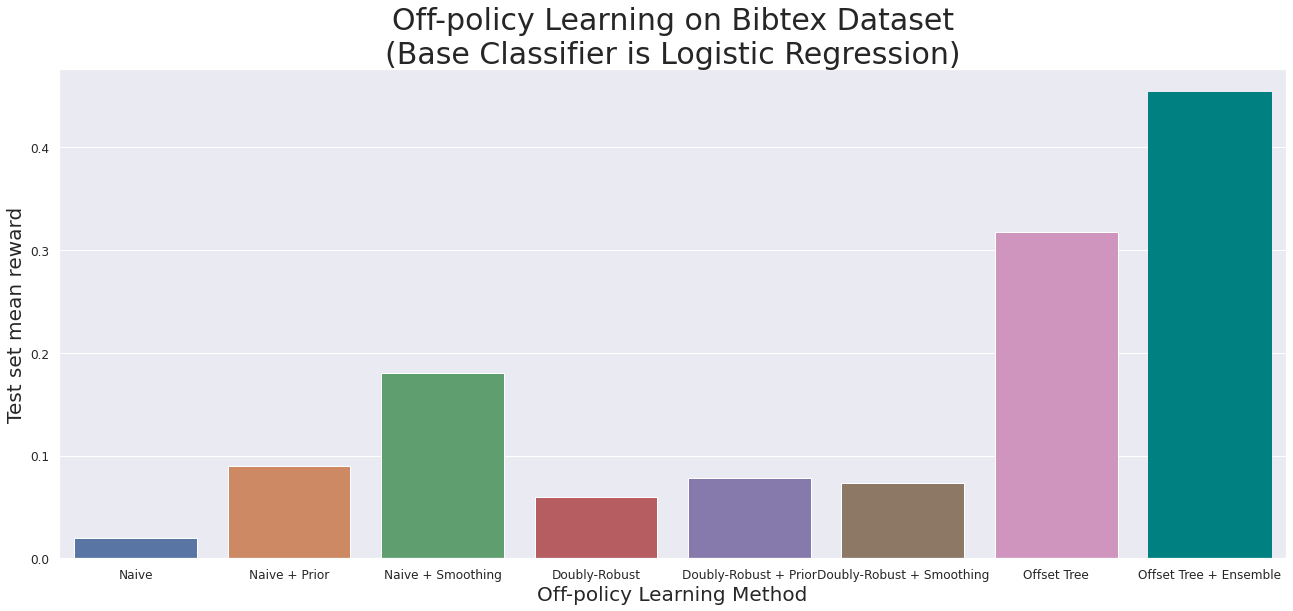

In [37]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                    'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree', 'Offset Tree + Ensemble'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot, mean_reward_ot_ensemble]
})

sns.set(font_scale = 1.1)
rcParams['figure.figsize'] = 22, 9
ax = sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
sns.set(font_scale=2.5)
plt.xlabel("Off-policy Learning Method", fontsize = 20)
plt.ylabel("Test set mean reward", fontsize = 20)
for bar in ax.patches:
    if bar.get_height() > 0.4:
        bar.set_color('teal')
plt.title('Off-policy Learning on Bibtex Dataset\n(Base Classifier is Logistic Regression)')
plt.show()

In [38]:
fig = ax.get_figure()
fig.savefig("Off_policy_MAB.png")